In [1]:
import os
import numpy as np
import cv2

import requests
import pytesseract
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

def plot(img, cmap=None):
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.imshow(img, cmap)

### Read images

In [2]:
all_imgs = [i for i in os.listdir('samples/') if i.endswith('.jpg')]
print(f'{len(all_imgs)} images in folder')
# plot(all_imgs[4])

172 images in folder


### Request to human detector

In [3]:
from src.human_detector_service.tensorflow_human_detection import DetectorAPI
from src.contour import Contour

/Users/cheena/PycharmProjects/runners_plate/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/cheena/PycharmProjects/runners_plate/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/cheena/PycharmProjects/runners_plate/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Use

In [4]:
model_path = 'src/human_detector_service/models/faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'
odapi = DetectorAPI(path_to_ckpt=model_path)
# threshold = 0.7

def detect_human(src_img, threshold = 0.95):
    shape = src_img.shape[1], src_img.shape[0]
    img = cv2.resize(src_img, (1280, 720))

    boxes, scores, classes, num = odapi.processFrame(src_img)
    boxes = [box for box, scores, _ in zip(boxes, scores, classes) if scores > threshold]
    # Visualization of the results of a detection.

    humans = []
    for cnt in boxes:
        y_l = cnt[0]
        x_l = cnt[1]
        y_r, x_r = cnt[2:]

        cropped_human = n_img[y_l: y_r, x_l: x_r]
        humans.append(cropped_human)

    print(f'\nDetected {len(humans)} humans in {name} image')
    return humans


Elapsed Time: 6.553255796432495

Detected 2 humans in bill-rodgers-boston-marathon-runner-former-winner-image-taken-color-slide-41950584.jpg image


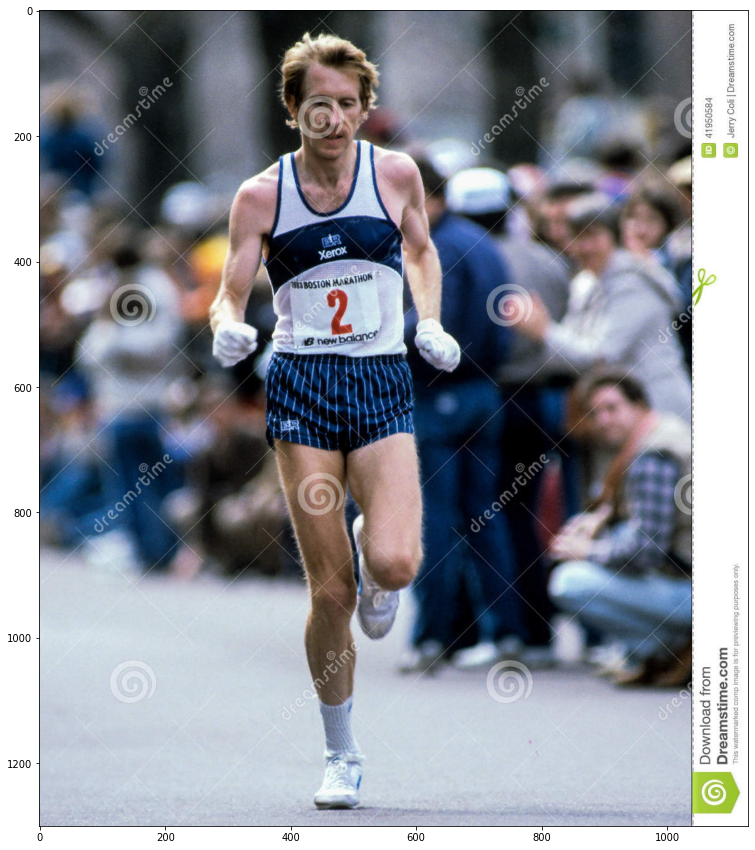

In [5]:
name = all_imgs[1]
img = open(f'samples/{name}', 'rb').read()
n_img = cv2.cvtColor(cv2.imread(f'samples/{name}'), cv2.COLOR_BGR2RGB)
plot(n_img)

humans = detect_human(n_img)

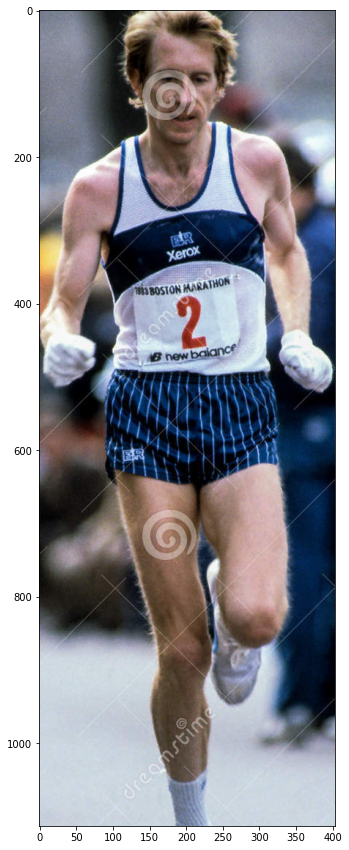

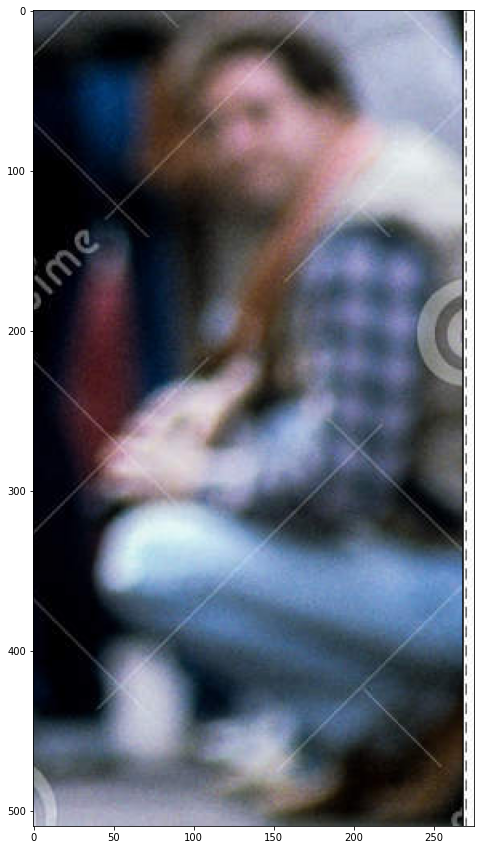

<Figure size 1080x1080 with 0 Axes>

In [6]:
# check humans
for i in humans:
    plot(i)
    plt.figure()

### Detect text on humans

In [7]:
from src.text_detector.text_detector import detect, crop

Loading model and optimizer from checkpoint 'src/text_detector/Detection/PSEnet/models/PSEnet_best.pth.tar.part'
Loaded checkpoint 'src/text_detector/Detection/PSEnet/models/PSEnet_best.pth.tar.part' (epoch 6)


In [8]:
boxed = []
text_save_path = 'src/text_recognition/cropped_text/'
!rm -rf {text_save_path}
!mkdir {text_save_path}

human_counter = 0
for test in tqdm_notebook(humans):
    h, w, c = test.shape
    boxes, text_on = detect(test.copy())
    # get detected text from humans
    for i, box in enumerate(boxes):
        cropped_text = crop(test.copy(), box)
        try:
            cv2.imwrite(f'{text_save_path}{human_counter}_{i}_{name}', cropped_text)
        except:
            print(f'Trouble with image {human_counter}_{i}_{name}')

/Users/cheena/PycharmProjects/runners_plate/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/Users/cheena/PycharmProjects/runners_plate/venv/lib/python3.6/site-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/Users/cheena/PycharmProjects/runners_plate/venv/lib/python3.6/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Trouble with image 0_0_bill-rodgers-boston-marathon-runner-former-winner-image-taken-color-slide-41950584.jpg



### Recognize text

In [9]:
output = !CUDA_VISIBLE_DEVICES=0 python3 src/text_recognition/demo.py \
--Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM --Prediction Attn \
--image_folder {text_save_path} \
--saved_model  src/text_recognition/model/TPS-ResNet-BiLSTM-Attn.pth

In [22]:
from IPython.core.display import display, HTML
from PIL import Image
import base64
import io
import pandas as pd

def postprocessing(text) -> str:
    changed_text = text
    changed_text = [str(s) for s in changed_text if s.isdigit()]
    if len(changed_text) > 1:
        return ''.join(changed_text)
    else:
        return False

data = pd.DataFrame()
for ind, row in enumerate(output[output.index('image_path               \tpredicted_labels         \tconfidence score')+2:]):
    row = row.split('\t')
    filename = row[0].strip()
    label = row[1].strip()
    label = postprocessing(label)
    conf = row[2].strip()
    if float(conf) > 0.7 and label:
        img = Image.open(filename)
        img_buffer = io.BytesIO()
        img.save(img_buffer, format="PNG")
        imgStr = base64.b64encode(img_buffer.getvalue()).decode("utf-8") 

        data.loc[ind, 'img'] = '<img src="data:image/png;base64,{0:s}">'.format(imgStr)
        data.loc[ind, 'id'] = filename
        data.loc[ind, 'label'] = label
        data.loc[ind, 'conf'] = conf

html_all = data.to_html(escape=False)
display(HTML(html_all))

In [23]:
output

['model input parameters 32 100 20 1 512 256 38 25 TPS ResNet BiLSTM Attn',
 'loading pretrained model from src/text_recognition/model/TPS-ResNet-BiLSTM-Attn.pth',
 '--------------------------------------------------------------------------------',
 'image_path               \tpredicted_labels         \tconfidence score',
 '--------------------------------------------------------------------------------',
 'src/text_recognition/cropped_text/0_0_bill-rodgers-boston-marathon-runner-former-winner-image-taken-color-slide-41950584.jpg\txerox                    \t0.4567',
 'src/text_recognition/cropped_text/0_1_bill-rodgers-boston-marathon-runner-former-winner-image-taken-color-slide-41950584.jpg\tsiaboston                \t0.3050',
 'src/text_recognition/cropped_text/0_2_bill-rodgers-boston-marathon-runner-former-winner-image-taken-color-slide-41950584.jpg\tnew                      \t0.9353']